# Data prepping: cleaning & features engineering

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import string
from functions.utilities import *
import seaborn as sns  

In [2]:
#to be able to have multiple output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#read the data
trainpath = './data/train.csv'
testpath = './data/test.csv'
traindf = pd.read_csv(trainpath, delimiter=",")
testdf = pd.read_csv(testpath, delimiter=",")
fulldf = traindf.merge(testdf, how="outer")

dfs = [fulldf, testdf, traindf]

#show the data set
fulldf.shape #returns (#lines, #columns)
fulldf.head()

#data type dictionary
data_type_dict={'PassengerId':'numeric',
                'Survived':'nominal',
                'Pclass':'ordinal',
                'Name':'nominal',
                'Sex':'nominal', 
                'Age':'numeric', 
                'SibSp':'numeric',
                'Parch':'numeric',
                'Ticket':'nominal',
                'Fare':'numeric', 
                'Cabin': 'nominal',
                'Embarked':'nominal'}

(1309, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Some quick data analysis

In [4]:
# check which columns have NA values
fulldf.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

We can see from the last table that some columns requires cleaning: Cabin, Embarked and Age.

In [5]:
#get an understanding of the possible values in relevant columns
fulldf.Pclass.unique()
fulldf.Sex.unique()
fulldf.SibSp.unique()
fulldf.Parch.unique()

array([3, 1, 2], dtype=int64)

array(['male', 'female'], dtype=object)

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

array([0, 1, 2, 5, 3, 4, 6, 9], dtype=int64)

### Tendencies 
*Source: https://towardsdatascience.com/kaggle-titanic-machine-learning-model-top-7-fa4523b7c40*

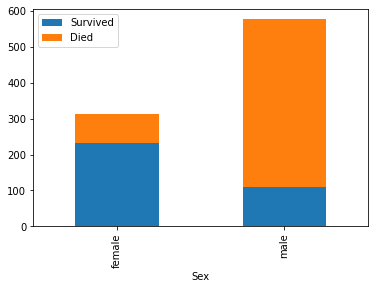

In [6]:
traindf['Died']=np.where(traindf['Survived'],0,1)
traindf.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked=True)

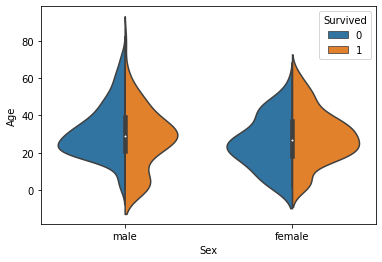

In [7]:
sns.violinplot(x='Sex', y='Age', hue='Survived', data=traindf, split=True)

### Pivot table
*Source: https://towardsdatascience.com/pivot-tables-in-pandas-7834951a8177*

In [8]:
GenderClass_pivot = pd.pivot_table(traindf, values=['Survived'], 
                        index='Pclass', 
                        columns='Sex',
                        aggfunc='mean',
                       )
GenderClass_pivot.round(2)

Survived      
Sex      female  male
Pclass               
1          0.97  0.37
2          0.92  0.16
3          0.50  0.14

From this, we can see pretty clearly that women are more likely to have survived, especially if they are from class 1 or 2. Man on the other hand were less fortunate, but they were more likely to have survived if they were from class 1.

## Data prepping

### Embarked: process missing values

In [9]:
fulldf.Embarked.unique()
fulldf[fulldf.Embarked.isna()]

array(['S', 'C', 'Q', nan], dtype=object)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Only two people don't have an embarking station. We looked if someone from the same family embarked with them but it did not help. The only result don't seem to be related. 

In [10]:
fulldf.Cabin = fulldf.Cabin.fillna('Unknown')
fulldf.loc[(fulldf["Name"].str.contains('Icard|Stone')) | (fulldf["Cabin"].str.contains('B28'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
319,320,1.0,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5,E34,C
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Instead, we fill the missing values with the most frequent one. First let's have a look at the most frequent embarcation point.

In [11]:
def nbEmbarked(df,embarked):
    return df.loc[(df['Embarked'] == embarked)].shape[0]

nb_Embarked = list(map(lambda x: nbEmbarked(fulldf, x), ['S', 'C', 'Q']))
nb_Embarked # (914, 270, 123)

[914, 270, 123]

Then, we look at the most frequent embarcation point for a female person of 1st class.

In [12]:
def nbEmbarked_missingNA(df,embarked):
    return df.loc[(df['Embarked'] == embarked) & (df['Sex'] == 'female') & (df['Pclass'] == 1)].shape[0]

nbEmbarked_missingNA = list(map(lambda x: nbEmbarked_missingNA(fulldf, x), ['S', 'C', 'Q']))
nbEmbarked_missingNA 

[69, 71, 2]

From this tabular, we see that given the class and the sex of the two persons, it is more likely that they embarked at "C".

In [13]:
def processEmbarked(df):
    df['Embarked'] = np.where((df['Embarked'].isna()), 'C', df['Embarked'])
    
updateAllDataSets(processEmbarked, dfs)

### Title: new feature

In [14]:
title_dict = {
    "Mrs": "Mrs",
    "Ms": "Mrs",
    "Mme": "Mrs",
    "Miss": "Miss",
    "Mlle": "Miss",
    "Mr": "Mr",
    "Master": "Master",
    "Major": "Officer",
    "Col": "Officer",
    "Capt": "Officer",
    "Rev": "Officer",
    "Dr": "Officer",
    "Countess": "Royalty",
    "Sir": "Royalty",
    "Lady": "Royalty",
    "Don": "Royalty",
    "Jonkheer": "Royalty"
}

def getTitles(df, dict, fulldf):
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, dict.keys()))
    data_type_dict['Title'] = 'nominal'
    df['Title'] = df['Title'].map(dict)
    
updateAllDataSets(getTitles, dfs, title_dict, fulldf)
fulldf.tail() # Dona ?

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,Unknown,S,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Royalty
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,Unknown,S,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,Unknown,S,Mr
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,Unknown,C,Master


### Cabin: 

In [15]:
fulldf.Cabin.unique()

array(['Unknown', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62

In [16]:
def peoplePerCat(df,category):
    return df.loc[(df['Pclass'] == category)].shape[0]

def unknownCabinsPerCat(df,category):
    return df.loc[(df['Cabin'] == "Unknown") & (df['Pclass'] == category)].shape[0]
 
categories = [1, 2, 3]
 
nb_unknown = fulldf.loc[(fulldf['Cabin'] == "Unknown")].shape[0] #1014
nb_unknownPerCat = list(map(lambda x: unknownCabinsPerCat(fulldf, x),categories))
nb_perCat = list(map(lambda x: peoplePerCat(fulldf, x), categories))
    
np.divide(nb_unknownPerCat,nb_perCat)

### TODO

array([0.20743034, 0.91696751, 0.977433  ])

### Cabin number: Getting the deck

In [17]:
#Turning cabin number into Deck
deck_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Unknown'] #T is removed as only used once

def addDeck(df, deck_list):
    df.Cabin = df.Cabin.fillna('Unknown')
    df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(x, deck_list))

updateAllDataSets(addDeck, dfs, deck_list)
testdf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,Unknown
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,Unknown
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Mr,Unknown
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mr,Unknown
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs,Unknown


### Age: missing values

In [18]:
fulldf.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [19]:
## Adding age for missing values (263)
grouped = fulldf.groupby(['Sex', 'Pclass', 'Title'])
grouped_median = grouped.median()
grouped_median
grouped_median = grouped_median.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

PassengerId  Survived   Age  SibSp  Parch       Fare
Sex    Pclass Title                                                        
female 1      Miss           521.0       1.0  30.0    0.0    0.0  106.42500
              Mrs            840.0       1.0  45.0    1.0    0.0   77.34375
              Officer        797.0       1.0  49.0    0.0    0.0   25.92920
              Royalty       1033.0       1.0  36.0    0.0    0.0   97.70000
       2      Miss           617.5       1.0  20.0    0.0    0.0   20.25000
              Mrs            518.0       1.0  30.0    0.5    0.0   26.00000
       3      Miss           603.5       0.5  18.0    0.0    0.0    8.05000
              Mrs            668.5       0.5  31.0    1.0    1.0   15.50000
male   1      Master         803.0       1.0   6.0    1.0    2.0  134.50000
              Mr             632.5       0.0  42.0    0.0    0.0   48.30210
              Officer        678.0       0.0  52.0    0.0    0.0   37.55000
              Royalty        427.0       0.0  39.0    0.0    0.0   13.86040
       2      Master         550.0       1.0   2.0    1.0    1.0   26.00000
              Mr             723.5       0.0  30.0    0.0    0.0   13.00000
              Officer        513.0       0.0  41.5    0.0    0.0   13.00000
       3      Master         789.0       0.0   6.0    3.0    1.0   22.35830
              Mr             640.5       0.0  26.0    0.0    0.0    7.89580

In [20]:
def fill_age(row, grouped):
    condition = (
        (grouped['Sex'] == row['Sex']) & 
        (grouped['Title'] == row['Title']) & 
        (grouped['Pclass'] == row['Pclass'])
    )
    return grouped[condition]['Age'].values[0]

def process_age(df, grouped):
    df['Age'] = df.apply(lambda row: fill_age(row, grouped) if np.isnan(row['Age']) else row['Age'], axis=1)
    
updateAllDataSets(process_age, dfs, grouped_median)

### Fare: process zero and missing values

In [21]:
fulldf.Fare.describe()
fulldf[fulldf.Fare.isna()]

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,Unknown,S,Mr,Unknown


One person doesn't have a fare and some people have a fare of zero (see min). Let's see how many.

In [22]:
for category in categories :
    print("# person whose fare is zero in category " + str(category) + ": " + str(len(fulldf.loc[(fulldf["Fare"]== 0) & (fulldf["Pclass"] == category)])))
    
#fulldf.loc[(fulldf["Fare"]== 0)]

# person whose fare is zero in category 1: 7
# person whose fare is zero in category 2: 6
# person whose fare is zero in category 3: 4


Now, let's induce the fare from the category by taking the median

In [23]:
def processFare(df, category, categories, fulldf):
    for category in categories :
        df['Fare'] = np.where(((df['Fare'].isna()) & (df['Pclass'] == category)), 
                              [fulldf.loc[fulldf['Pclass'] == category].loc[:,"Fare"].median()] , 
                              df['Fare'])
        df['Fare'] = np.where(((df['Fare'] == 0) & (df['Pclass'] == category)), 
                              [fulldf.loc[fulldf['Pclass'] == category].loc[:,"Fare"].median()] , 
                              df['Fare'])
updateAllDataSets(processFare, dfs, category, categories, fulldf)

### Creating bins for the fare

In [24]:
fare_bin_edges = [0,
                  fulldf['Fare'].quantile(0.2),
                  fulldf['Fare'].quantile(0.4),
                  fulldf['Fare'].quantile(0.6),
                  fulldf['Fare'].quantile(0.8),
                  fulldf['Fare'].quantile(0.9),
                  max(fulldf['Fare'])+1]

def addFareBins(df, fare_bin_edges):
    df['Fare_bins'] = pd.cut(df['Fare'], 
                             fare_bin_edges, 
                             labels=[1,2,3,4,5,6])
    
updateAllDataSets(addFareBins, dfs, fare_bin_edges)
fulldf.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Fare_bins
1304,1305,NaN,3,"Spector, Mr. Woolf",male,26.0,0,0,A.5. 3236,8.0500,Unknown,S,Mr,Unknown,2
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Royalty,C,6
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,Unknown,S,Mr,Unknown,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,26.0,0,0,359309,8.0500,Unknown,S,Mr,Unknown,2
1308,1309,NaN,3,"Peter, Master. Michael J",male,6.0,1,1,2668,22.3583,Unknown,C,Master,Unknown,3


### Family: Size of the family

In [25]:
def processFamily(df):
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    df['NoFamily'] = df['FamilySize'].map(lambda x: 1 if x == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda x: 1 if 2 <= x <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda x: 1 if 5 <= x else 0)
    
updateAllDataSets(processFamily, dfs)

## Reducing the number of features
Let's have a look at our data set with all this data prepping

In [26]:
fulldf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Fare_bins,FamilySize,NoFamily,SmallFamily,LargeFamily
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,Unknown,1,2,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,5,2,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,Unknown,2,1,1,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,5,2,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,Unknown,2,1,1,0,0


First we will use dummies for Sex, Embarked, Deck and Title.

Then, we will remove :
  * Name, replaced by Title
  * Cabin, replaced by Deck
  * Fare, replaced by Fare_bins
  * FamilySize, replaced by no/small/large family
  * Deck, replaced by dummies
  * Deck_Unknown, from the dummies and giving no infos
  * Embarked, replaced by dummies
  * Sex, replaced by dummies
  * Title, replaced by dummies
  * Ticket, as it does not seem relevant

In [27]:
def dummies(df):
    title_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, title_dummies], axis=1)
    
    deck_dummies = pd.get_dummies(df['Deck'], prefix='Deck')
    df = pd.concat([df, deck_dummies], axis=1)
    
    embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, embarked_dummies], axis=1)
    
    sex_dummies = pd.get_dummies(df['Sex'], prefix='Sex')
    df = pd.concat([df, sex_dummies], axis=1)
    
    return df    
    
def drop_features(df):
    df.drop(axis=1, 
            labels=['Name', 'Cabin', 'Fare', 'FamilySize', 'Deck', 'Deck_Unknown', 'Embarked', 'Sex', 'Title',  'Ticket'], 
            inplace=True)

testdf = dummies(testdf)
traindf = dummies(traindf)
fulldf = dummies(fulldf)

dfs = [fulldf, testdf, traindf]
updateAllDataSets(drop_features, dfs)
testdf.head()
fulldf.tail()

,PassengerId,Pclass,Age,SibSp,Parch,Fare_bins,NoFamily,SmallFamily,LargeFamily,Title_Master,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,892,3,34.5,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,893,3,47.0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,894,2,62.0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,895,3,27.0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,896,3,22.0,1,1,3,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare_bins,NoFamily,SmallFamily,LargeFamily,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
1304,1305,NaN,3,26.0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1305,1306,NaN,1,39.0,0,0,6,1,0,0,...,1,0,0,0,0,1,0,0,1,0
1306,1307,NaN,3,38.5,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1307,1308,NaN,3,26.0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1308,1309,NaN,3,6.0,1,1,3,0,1,0,...,0,0,0,0,0,1,0,0,0,1


## Correlation matrix
*Source: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas*

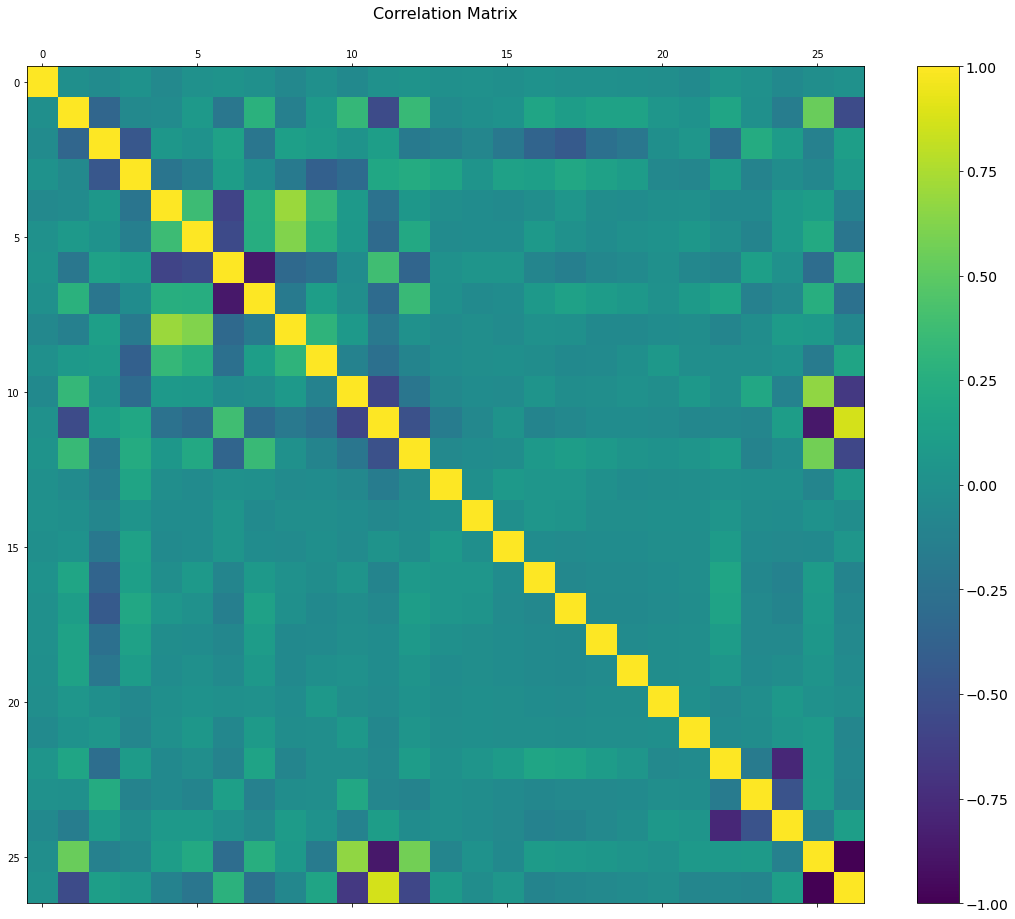

In [28]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(fulldf.corr(), fignum=f.number)
#plt.xticks(range(fulldf.shape[1]-1), fulldf.columns, fontsize=14, rotation=45)
#plt.yticks(range(fulldf.shape[1]-1), fulldf.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Output

In [29]:
testdf.to_csv("testdf-2.csv", index=False)
traindf.to_csv("traindf-2.csv",index=False)